In [1]:
!pip install ninja matplotlib tqdm opencv-python numpy pandas tensorboard timm==0.9.2
!pip install scipy captum
!pip install triton==2.0.0

In [214]:
# Vision Transformer (ViT) Fine-tuning on CIFAR-10 using PyTorch and timm

import torch
import torchvision
import torchvision.transforms as transforms
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, Saliency
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# TensorBoard writer
writer = SummaryWriter(log_dir='runs/vit_cifar10')

Using device: cuda


In [4]:
# Transformations for CIFAR-10 (resize to 224x224 for ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Load pre-trained ViT model from timm and adapt for CIFAR-10
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)


In [7]:
model.parameters

<bound method Module.parameters of VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inpla

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [9]:
# Training loop
epochs = 10
best_acc = 0.0
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i + 1) % 100 == 0:
            avg_loss = running_loss / 100
            acc = 100 * correct / total
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], "
                  f"Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
            writer.add_scalar('Training Loss', avg_loss, epoch * len(train_loader) + i)
            writer.add_scalar('Training Accuracy', acc, epoch * len(train_loader) + i)
            running_loss = 0.0

    scheduler.step()

    # Save checkpoint if accuracy improves
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    acc = 100 * correct_test / total_test
    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch + 1} Test Accuracy: {acc:.2f}%")
    writer.add_scalar('Test Accuracy', acc, epoch)
    writer.add_scalar('Test Loss', avg_test_loss, epoch)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'checkpoints/vit_cifar10_best.pth')
        print("Best model updated.")

print("Training complete. Best model saved.")
writer.close()

Epoch [1/10], Step [100/6250], Loss: 1.0464, Accuracy: 66.50%
Epoch [1/10], Step [200/6250], Loss: 0.7140, Accuracy: 71.94%
Epoch [1/10], Step [300/6250], Loss: 0.5734, Accuracy: 74.92%
Epoch [1/10], Step [400/6250], Loss: 0.6409, Accuracy: 75.94%
Epoch [1/10], Step [500/6250], Loss: 0.5951, Accuracy: 76.97%
Epoch [1/10], Step [600/6250], Loss: 0.5808, Accuracy: 77.67%
Epoch [1/10], Step [700/6250], Loss: 0.5670, Accuracy: 78.30%
Epoch [1/10], Step [800/6250], Loss: 0.4996, Accuracy: 79.11%
Epoch [1/10], Step [900/6250], Loss: 0.5099, Accuracy: 79.40%
Epoch [1/10], Step [1000/6250], Loss: 0.4323, Accuracy: 79.99%
Epoch [1/10], Step [1100/6250], Loss: 0.4789, Accuracy: 80.38%
Epoch [1/10], Step [1200/6250], Loss: 0.4248, Accuracy: 80.89%
Epoch [1/10], Step [1300/6250], Loss: 0.4710, Accuracy: 81.16%
Epoch [1/10], Step [1400/6250], Loss: 0.4697, Accuracy: 81.29%
Epoch [1/10], Step [1500/6250], Loss: 0.4754, Accuracy: 81.49%
Epoch [1/10], Step [1600/6250], Loss: 0.4576, Accuracy: 81.73%
E

In [563]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [564]:
# Captum: Integrated Gradients Visualization
model.eval()
ig = IntegratedGradients(model)

In [571]:
def get_preds_and_IGattributes(image_tensor,taget_class):
    result = model(image_tensor)
    _, pred_class_idx = result.max(1)
    pred_class = train_dataset.classes[pred_class_idx]

    # Compute attributions
    ig_attributions, delta = ig.attribute(image_tensor, target=target_class, return_convergence_delta=True)

    return pred_class, ig_attributions #, saliency_attributions

In [572]:
# Visualization
def show_attributions(orig, attr, perturbation=""):
    orig = orig.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    orig = (orig * 0.5) + 0.5  # Unnormalize
    attr = attr.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    attr = np.abs(attr).mean(axis=2)  # Convert to grayscale heatmap

    fig, ax = plt.subplots(2, 1, figsize=(2, 4))
    ax[0].imshow(orig)
    ax[0].set_title(perturbation + " Input Image")
    ax[0].axis('off')

    ax[1].imshow(orig)
    ax[1].imshow(attr, cmap='hot', alpha=1.0)
    ax[1].set_title("Attribution Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [573]:
dataiter = iter(test_loader)

In [574]:
# Get one batch of test images
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

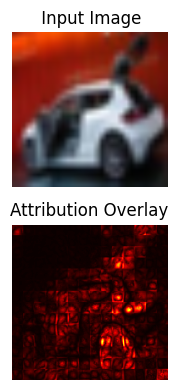

Predicted class -  automobile
Target class    -  automobile


In [577]:
# Select an image from the test dataset
index = 6
input_img = images[index].unsqueeze(0).requires_grad_(True)
target_class = labels[index].item()

predicted_class, IG_attr = get_preds_and_IGattributes(input_img, target_class)
show_attributions(input_img, IG_attr)
print("Predicted class - ", predicted_class)
print("Target class    - ", train_dataset.classes[target_class])

In [578]:
# Load image
img = Image.open("./data/test_images/dog-in-grass.jpg").convert('RGB')

# Show the image
#img.show()

In [579]:
input_tensor = transform(img).unsqueeze(0).to(device)
#result = model(input_tensor)

target_class = 5
predicted_class, IG_attr = get_preds_and_IGattributes(input_tensor, target_class)

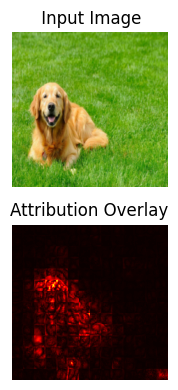

Predicted class -  dog
Target class    -  dog


In [580]:
show_attributions(input_tensor, IG_attr)
print("Predicted class - ", predicted_class)
print("Target class    - ", train_dataset.classes[target_class])

In [581]:
# Perturbation analysis - Impact of Blur on model prediction and Integrated Gradients

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# Perturbation: Blur a region (e.g., center box)
img_blurred = img.copy()
blurred_region = img.crop((180, 180, 400, 400)).filter(ImageFilter.GaussianBlur(radius=100))
img_blurred.paste(blurred_region, (180, 180))

# Transform perturbed image
input_tensor_blurred = transform(img_blurred).unsqueeze(0).to(device)

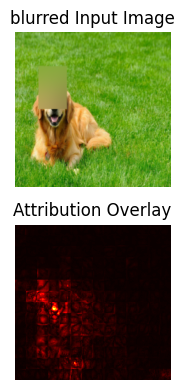

Predicted class -  deer
Target class    -  dog


In [582]:
target_class = 5
blurred_predicted_class, blurred_IG_attr = get_preds_and_IGattributes(input_tensor_blurred, target_class)

show_attributions(input_tensor_blurred, blurred_IG_attr, "blurred")
print("Predicted class - ", blurred_predicted_class)
print("Target class    - ", train_dataset.classes[target_class])

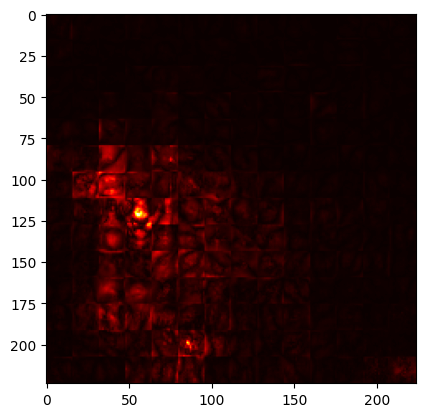

In [583]:
# Blown up viz of the blurred integrated gradients
blurred_IG_attr_viz = blurred_IG_attr.squeeze().cpu().permute(1, 2, 0).detach().numpy()
blurred_IG_attr_viz = np.abs(blurred_IG_attr_viz).mean(axis=2)  # Convert to grayscale heatmap

plt.imshow(blurred_IG_attr_viz, cmap="hot")